# importing libs

In [15]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

from keras.applications.vgg16 import VGG16 
from keras.models import Model

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from cv2 import resize, INTER_LINEAR

import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
from scipy.special import comb
from itertools import combinations

# Evaluation Tools

In [2]:
def rand_index_score(actual_labels, predicted_labels):
    tp_plus_fp = comb(np.bincount(actual_labels), 2).sum() # true positive + false positive
    tp_plus_fn = comb(np.bincount(predicted_labels), 2).sum() # true positive + false negative

    A = np.c_[(actual_labels, predicted_labels)]

    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum() for i in set(actual_labels))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

compute rand index, from cluster arg which are actual label, and classes which are predicted labels by the algorithm.

*  bincount -> Count number of occurrences of each value in array of non-negative ints.


*  comb -> combination

In [3]:
class Cluster:

  def __init__(self, cluster_id: int):
    self.predicted_file_names = []
    self.actual_file_names_labels = []
    self.cluster_id = cluster_id # integer
    self.predicted_label = None
  
  def infer_cluster_label(self):
    self.predicted_label = max(self.actual_file_names_labels, key=self.actual_file_names_labels.count)

  
  def predicted_and_actual_label_list(self):
    if not self.predicted_label:
      raise Exception('predicted label was not inferred')
    preds = [self.predicted_label] * len(self.predicted_file_names)

    return self.actual_file_names_labels, preds

  def build_cluster_objects_from(algorithm, persons_file_names, actual_unique_labels):
    clusters = [] # indexes are cluster id
    
    if hasattr(algorithm, 'n_clusters') and algorithm.n_clusters is not None:
      n_clusters = algorithm.n_clusters
    elif hasattr(algorithm, 'n_clusters_') and algorithm.n_clusters_ is not None:
      n_clusters = algorithm.n_clusters_
    else:
      n_clusters = len(set(algorithm.labels_))
    
    for cluster_id in range(1, n_clusters + 1):
      clusters.append(Cluster(cluster_id=cluster_id))
    
    for file_name, predicted_cluster_id, actual_label in zip(persons_file_names, algorithm.labels_, actual_unique_labels):
      clusters[predicted_cluster_id - 1].predicted_file_names.append(file_name) # append file while it is predicted for this cluster 
      clusters[predicted_cluster_id - 1].actual_file_names_labels.append(actual_label) # append the real label for this file name
    
    return clusters

This class holds each cluster data including labels, datas, actual labels and inffered label for cluster. 

In [4]:
class ClusterWorker:

  def __init__(self, algorithm, features):
    self.algorithm = algorithm
    self.features = features
    self.flattened_predicted_labels = np.array([]).astype(np.int64)
    self.flattened_actual_label = np.array([]).astype(np.int64)

  def perform(self):
    self.algorithm.fit(self.features)

    # if hasattr(self.algorithm, 'n_clusters') and self.algorithm.n_clusters is not None:
    #   n_clusters = self.algorithm.n_clusters
    # elif hasattr(self.algorithm, 'n_clusters_') and self.algorithm.n_clusters_ is not None:
    #   n_clusters = self.algorithm.n_clusters_
    # else:
    #   n_clusters = len(set(self.algorithm.labels_))
    # print(n_clusters)

    self._infer_lables()
  
  def _infer_lables(self):
    kmeans_clusters = Cluster.build_cluster_objects_from(self.algorithm, persons_file_names, unique_labels_list)

    preds = np.array([]).astype(np.int64)
    acs = np.array([]).astype(np.int64)
    
    for cl in kmeans_clusters:
      cl.infer_cluster_label()
      ac, pred = cl.predicted_and_actual_label_list()
      preds = np.append(preds, pred)
      acs = np.append(acs, ac)

    self.flattened_predicted_labels = preds.flatten()
    self.flattened_actual_label = acs.flatten()

  def n_cluster(self):
    return len(set(self.algorithm.labels_))
  
  def rand_index(self):
    return metrics.adjusted_rand_score(self.flattened_actual_label, self.flattened_predicted_labels)

  def self_implemented_rand_index(self):
    return rand_index_score(self.flattened_actual_label, self.flattened_predicted_labels)

  def purity(self):
    return metrics.accuracy_score(self.flattened_actual_label, self.flattened_predicted_labels)

  def print_statictics(self):
    print('Predicted labels: {}'.format(self.flattened_predicted_labels[:30]))
    print('Actual labels:    {}'.format(self.flattened_actual_label[:30]))
    print('Purity: {}'.format(metrics.accuracy_score(self.flattened_actual_label, self.flattened_predicted_labels)))
    print('Rand Index: {}'.format(metrics.adjusted_rand_score(self.flattened_actual_label, self.flattened_predicted_labels)))
    print('Rand Index self implemenetd: {}'.format(rand_index_score(self.flattened_actual_label, self.flattened_predicted_labels)))
    print()

This is a wrapper for each algorithm we use.
it can infer clusters labels, purity and rand index.

In [5]:
class ClusterStatictics:

  def measure(self):
    pass

  def plot_statistics(self):
    pass

Abstract class for measuring statistics

# Loading Data

In [6]:
path = r"/content/drive/MyDrive/AI/Clustering/ORL"

os.chdir(path)

persons_file_names = []

with os.scandir(path) as files:

    for file in files:
        if file.name.endswith('.jpg'):

          base = os.path.basename(file)
          name = os.path.splitext(base)[0]
          persons_file_names.append(name)


Load filenames wothouy .jpg extension

In [7]:
# model = VGG16()
# model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

cnn model which we can use to improve clustering

In [8]:
def extract_features(file, model):
    file_path = '/content/drive/MyDrive/AI/Clustering/ORL' + '/' + file + '.jpg'

    img = load_img(file_path, target_size=(224,224))

    img = np.array(img)

    if model:
      reshaped_img = img.reshape(1,224,224,3)

      imgx = preprocess_input(reshaped_img)

      features = model.predict(imgx, use_multiprocessing=True)

      return features
    else:
      img = img.reshape(img.shape[0], (img.shape[1]*img.shape[2]))

      return img

feature extractor method can use cnn or pixels

> in order to use pixel we should reshape it to 2-dim array from 3-dim

In [9]:
data = {}

for person_name in persons_file_names:
    try:
        # feat = extract_features(person_name, model)
        feat = extract_features(person_name, None)
        data[person_name] = feat
    except:
      print('execp')
      continue

extract features for each image and store them in dic

# Data Preprocessing

In [10]:
def find_images_labels(persons_file_names):
  ids = list()
  for name in persons_file_names:
    splited = name.split('_')[1]
    ids.append(int(splited))
  
  return ids, set(ids)

extract label from image name

In [11]:
filenames = np.array(list(data.keys()))

feat = np.array(list(data.values()))

feat = feat.reshape(feat.shape[0], (feat.shape[1]*feat.shape[2]))

# feat = feat.reshape(-1,4096)

unique_labels_list, unique_labels_set = find_images_labels(persons_file_names)

preapare data for being used in algorithm

In [12]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
transformed_pca = pca.transform(feat)

Componnent reducer for faster computation

# KMeans

In [ ]:

k_means_mini_batch = ClusterWorker(MiniBatchKMeans(n_clusters=len(unique_labels_set), random_state=22), feat)
k_means_mini_batch.perform()
k_means_mini_batch.print_statictics()

k_means = ClusterWorker(KMeans(n_clusters=len(unique_labels_set), random_state=22), feat)
k_means.perform()
k_means.print_statictics()


Predicted labels: [32 32 32 32 32 32 32 32 32 41 41 41 41 41 41 41 41 13 13 13 13 13 13 13
 13 13 13 22 22 22]
Actual labels:    [32 32 32 32 32 32 32 32 32 41 41 41 41 41 41 41 41 13 13 13 13 13 13 13
 13 13 13 22 39 39]
Purity: 0.7146341463414634
Rand Index: 0.6159978637478812

Predicted labels: [32 32 32 32 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 23 23 23 23
 23 23 23 23 23 23]
Actual labels:    [32 32 32 32 26 26 12 12 12 12 12 12 12 26 26 12 12 26 26 12 23  9  9 23
 23  9 20 20  9 23]
Purity: 0.675609756097561
Rand Index: 0.5642560791006547



The above code is for testing the clustering. 
I once cluster the dataset using the K-Means-MiniBatch algorithm and once use the normal K-Means. 
The difference between these two algorithm is that the MiniBatch algorithm is much faster than the normal K-means.

But the MiniBatch algorithm has a lower Purity and Rand Index, which is visible when you run the above code. 

In [ ]:
class KmeansClusterStatictics(ClusterStatictics):

  def __init__(self, features):
    self.features = features
    self.clusters = [10, 20, 40, 60, 80, 100]
    self.rand_indexes = []
    self.purities = []
  
  def measure(self):
    for i in self.clusters:
      k_means_mini_batch = ClusterWorker(MiniBatchKMeans(n_clusters=i, random_state=22), self.features)
      k_means_mini_batch.perform()
      
      purity = k_means_mini_batch.purity()
      rand_index = k_means_mini_batch.rand_index()
      
      self.rand_indexes.append(rand_index)
      self.purities.append(purity)

  def plot_statistics(self):
    plt.plot(self.clusters, self.purities)
    plt.suptitle('Effect Of Cluster Count On Purity')
    plt.show()
    plt.plot(self.clusters, self.rand_indexes)
    plt.suptitle('Effect Of Cluster Count On Rand-Index')
    plt.show()

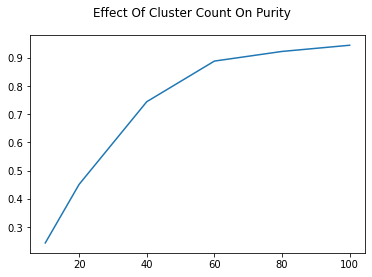

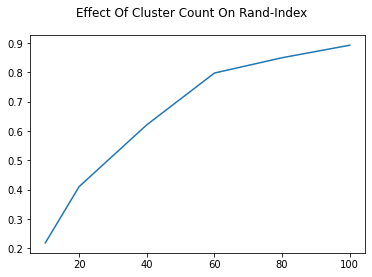

In [ ]:
kmeans_stat = KmeansClusterStatictics(features=feat)
kmeans_stat.measure()
kmeans_stat.plot_statistics()

The above code is MiniBatch K-Means but with differnet values for n_cluster. 
We can see that with more clusters, we gain more purity and rand-index. 

# DBScan

In [20]:
class EpsilonPredictor:

  def __init__(self, features):
    self.features = features
    self.neighbour = NearestNeighbors(n_neighbors=2)
    self.distances = []
  
  def measure(self):
    nbrs = self.neighbour.fit(self.features)
    self.distances, indices = nbrs.kneighbors(self.features)
    self.distances = np.sort(self.distances, axis=0)
    self.distances = self.distances[:,1]
  
  def plot_result(self):
    plt.suptitle('Datas in Distance Range')
    plt.xlabel("Data")
    plt.ylabel("Epsilons")
    plt.plot(self.distances)
    plt.show()

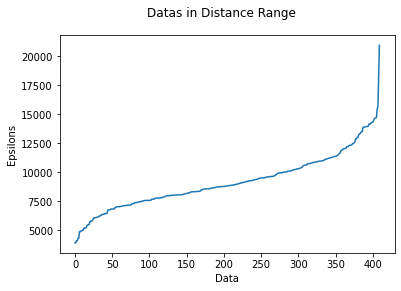

In [21]:
eps_predictor = EpsilonPredictor(feat)
eps_predictor.measure()
eps_predictor.plot_result()

The above code is for figuring out that which epsilon is ideal for our dataset.<br>

To estimate an ideal epsilon, I used the NearestNeighbor library. first I find the differences between all the data, then by sorting it, we can find that how much distance the datas have. 
For example as you can see in the plot, lower than distance 7000 and higher than distance 15000 will decrease the accuracy of our cluster, because most of our data are between the range 7000 to 15000. 
For example as you can see in the plot, lower than distance 7000 and higher than distance 6 will decrease the accuracy of our cluster, because most of our data are between the range 7000 to 15000. 
In other words, less than distance 7000, algorithm will count most of our data as noisy, and more than distance , algorithm will put most of our data in one cluster. 
In the next code we will try different epsilons between 5000 to 15000.

In [39]:
class DBSCANQuality:

  def __init__(self, features):
    self.features = features
    self.epsilons = [ep for ep in range(5000,16000, 500)]
    self.rand_indexes = []
    self.purities = []
    self.n_clusters = []
  
  def measure(self):
    for ep in self.epsilons:
      dbscan = ClusterWorker(DBSCAN(min_samples=1, eps=ep), features=self.features)
      dbscan.perform()
      # dbscan.print_statictics()

      purity = dbscan.purity()
      rand_index = dbscan.rand_index()
      n_cluster = dbscan.n_cluster()

      self.rand_indexes.append(rand_index)
      self.purities.append(purity)
      self.n_clusters.append(n_cluster)
  
  def plot_result(self):
    plt.plot(self.epsilons, self.purities)
    plt.suptitle('Epsilon on Purity')
    plt.xlabel("Epsilons")
    plt.ylabel("Purities")
    plt.show()

    plt.plot(self.epsilons, self.rand_indexes)
    plt.suptitle('Epsilon on Rand-Index')
    plt.xlabel("Epsilons")
    plt.ylabel("Rand Indexes")
    plt.show()

    plt.plot(self.epsilons, self.n_clusters)
    plt.suptitle('Epsilon on Number of Clusters')
    plt.xlabel("Epsilons")
    plt.ylabel("Clsuters")
    plt.show()

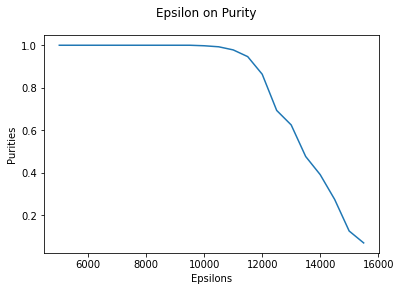

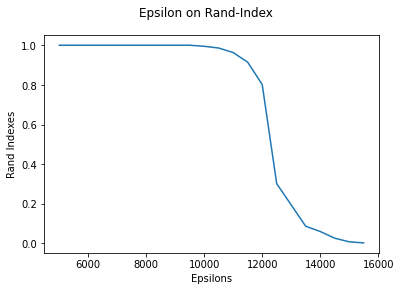

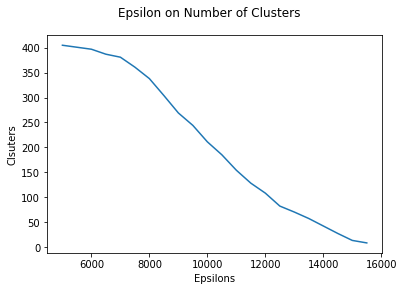

In [40]:
eps_predictor = DBSCANQuality(feat)
eps_predictor.measure()
eps_predictor.plot_result()

In the above code you can clearly see that for epsilons lower than 7000, we had a cluster for each data, which results into high purity and rand-index but not usefull. and for epsilons more than 15000 we get less clusters which results into bad accuracy and purity. <br>
But if we choose epsilons between 7000 to 15000, it's more ideal. and according to the plots, epsilon 12000 is the best for this dataset.

In [41]:
class DBSCANNoise:

  def __init__(self, features):
    self.features = features
    self.min_samples = [1, 2, 3, 4, 5]
    self.noise_percentage = []
  
  def measure(self):
    for i in self.min_samples:
      dbscan = DBSCAN(eps=12000, min_samples=i)
      dbscan.fit(self.features)
      index = np.where(dbscan.labels_ == -1) # noisy datas are labeled as -1
      self.noise_percentage.append(len(index[0])/1000)
  
  def plot_result(self):
    plt.plot(self.min_samples, self.noise_percentage)
    plt.suptitle('Minimum samples on Noisy data percentage')
    plt.xlabel("Min Samples")
    plt.ylabel("Noise Percentage")
    plt.show()

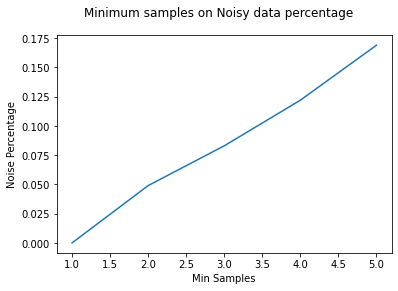

In [42]:
db_noise_mes = DBSCANNoise(feat)
db_noise_mes.measure()
db_noise_mes.plot_result()

shows the effect of min sample on the amount of noisy datas recognized. 

# Agglomerative

In [60]:
class AgglomerativeThreshHoldStat(ClusterStatictics):

  def __init__(self, features):
    self.features = features
    self.thresholds = [i for i in range(10000,26000, 1000)]
    self.rand_indexes = []
    self.purities = []
    self.n_clusters = []
  
  def measure(self):
    for i in self.thresholds:
      al = AgglomerativeClustering(distance_threshold=i, n_clusters=None, compute_full_tree=True)
      agglo = ClusterWorker(al, features=self.features)
      agglo.perform()
      # agglo.print_statictics()

      purity = agglo.purity()
      rand_index = agglo.rand_index()
      n_cluster = agglo.n_cluster()
      self.rand_indexes.append(rand_index)
      self.purities.append(purity)
      self.n_clusters.append(n_cluster)

  def plot_statistics(self):
    plt.plot(self.thresholds, self.purities)
    plt.xlabel("Thresholds")
    plt.ylabel("Purities")
    plt.suptitle('Threshold on Purity')
    plt.show()
    plt.plot(self.thresholds, self.rand_indexes)
    plt.suptitle('Threshold on Rand-Index')
    plt.xlabel("Thresholds")
    plt.ylabel("Rand-Indexes")
    plt.show()
    plt.plot(self.thresholds, self.n_clusters)
    plt.suptitle('Threshold on Number of Clusters')
    plt.xlabel("Thresholds")
    plt.ylabel("Clsuters")
    plt.show()


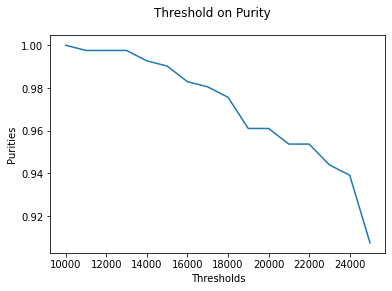

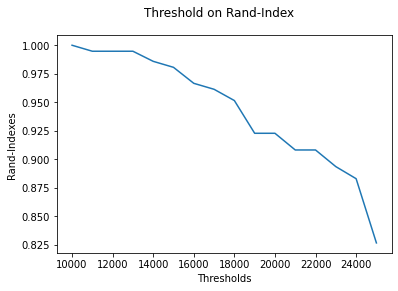

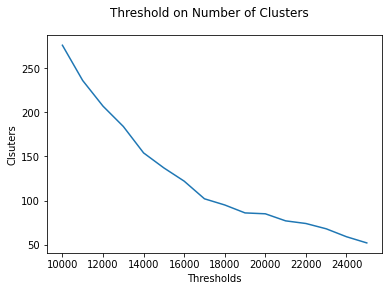

In [61]:
agllo_threshold_stats = AgglomerativeThreshHoldStat(feat)
agllo_threshold_stats.measure()
agllo_threshold_stats.plot_statistics()

As you can see, by increasing the threshold, we gain less purity and rand-index. <br>
The ideal amount for threshold is between 16000 to 22000, because the number of clusters are acceptable and also the purity and rand-index is very good. <br>

In [64]:
class AgglomerativeStat(ClusterStatictics):

  def __init__(self, features):
    self.features = features
    self.n_clusters = [10, 20, 41, 50, 60, 70]
    self.rand_indexes = []
    self.purities = []
  
  def measure(self):
    for i in self.n_clusters:
      agglo = ClusterWorker(AgglomerativeClustering(n_clusters=i),
                            features=self.features)
      agglo.perform()
      # agglo.print_statictics()

      purity = agglo.purity()
      rand_index = agglo.rand_index()
      self.rand_indexes.append(rand_index)
      self.purities.append(purity)

  def plot_statistics(self):
    plt.plot(self.n_clusters, self.purities)
    plt.suptitle('Number of Cluster on Purity')
    plt.xlabel("Cluster")
    plt.ylabel("Purities")
    plt.show()

    plt.plot(self.n_clusters, self.rand_indexes)
    plt.suptitle('Number of Cluster on Rand-Index')
    plt.xlabel("Cluster")
    plt.ylabel("Rand-Indexes")
    plt.show()

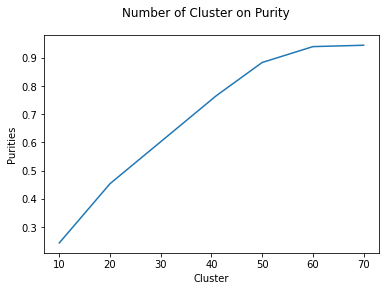

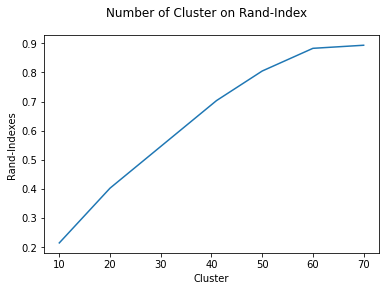

In [65]:
agllo_stats = AgglomerativeStat(feat)
agllo_stats.measure()
agllo_stats.plot_statistics()

Another way of agglomerative algorithm is to define the maximum number of clusters, just like K-means, and the algorithm will do clustering until number of clusters reach the limit. <br>
You can see that after 50 clusters, we won't gain that much purity and rand-index comparing to previous numbers. 

In [68]:
class AgglomerativeTypeStat(ClusterStatictics):

  def __init__(self, features):
    self.features = features
    self.types = ['ward', 'complete', 'average', 'single']
    self.rand_indexes = []
    self.purities = []
  
  def measure(self):
    for t in self.types:
      agglo = ClusterWorker(AgglomerativeClustering(n_clusters=41, linkage=t),
                            features=self.features)
      agglo.perform()
      # agglo.print_statictics()

      purity = agglo.purity()
      rand_index = agglo.rand_index()

      self.rand_indexes.append(rand_index)
      self.purities.append(purity)

  def plot_statistics(self):
    plt.plot(self.types, self.purities)
    plt.suptitle('Type on Purity')
    plt.xlabel("Types")
    plt.ylabel("Purities")
    plt.show()

    plt.plot(self.types, self.rand_indexes)
    plt.suptitle('Type on Rand-Index')
    plt.xlabel("Types")
    plt.ylabel("Rand-Index")
    plt.show()

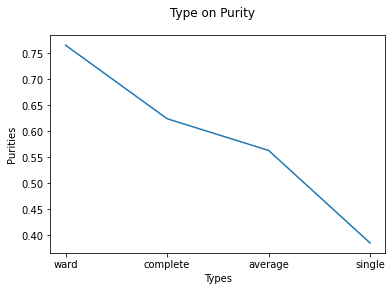

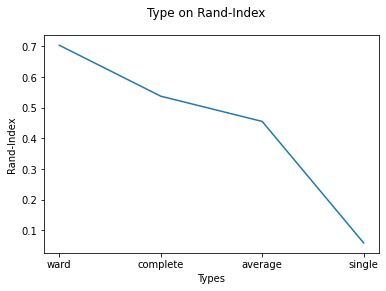

In [69]:
agllo_type_stats = AgglomerativeTypeStat(feat)
agllo_type_stats.measure()
agllo_type_stats.plot_statistics()

The agglomerative algorithm has 4 different types. <br>
The default value for the type is 'ward' and up to now we have used this type for our previous examples. <br>
Here in this example we can see the effect of the type on the accuracy of our clustering. <br>
As you can see the complete and average doesn't have much difference, the ward type is the best and the single type is the worst.